<a href="https://colab.research.google.com/github/debanandasen/Tensorflow/blob/main/04_transfer_learning_in_temsorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with Tensorflow Part 1: Feature Extraction

There are two main benefits to using transfer learning:

1) Can leverage an existing neural network architecture proven to work on
   problems similar to our own.
   
2) Can leverage a working neural network architecture which has already learned
   patterns on similar data to our own. This often results in achieving great results with less custom data.

In [1]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")


# Are we running a GPU
!nvidia-smi

Notebook last run (end-to-end): 2023-09-24 13:46:20.457282
Sun Sep 24 13:46:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                             

## Transfer Learning with Tensorflow HUb: with 10% of the data

In [2]:
# Download and becoming one with Data
import zipfile
# Downlaod Data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-09-24 13:46:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   182MB/s    in 0.9s    

2023-09-24 13:46:23 (182 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder ?

import os

# Walk through 10 percent data dictionary and list number of files
for dirpath,dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} impages in '{dirpath}'.")


There are 2 directories and 0 impages in '10_food_classes_10_percent'.
There are 10 directories and 0 impages in '10_food_classes_10_percent/test'.
There are 0 directories and 250 impages in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 impages in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 impages in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 impages in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 impages in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 impages in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 impages in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 impages in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 impages in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 impages in '10_food_classes_10_per

## Create data loaders (Preparing the data)

In [4]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Images")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")





Training Images:
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


## Setting up callbacks( things to run whilst our model trains)

In [5]:
from tensorflow.python.ops.gen_linalg_ops import log_matrix_determinant_eager_fallback
# Create TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir =log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating model using tensorflow Hub
Feature vector model link
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [6]:
# Let's compare the following tow model
resnet_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [8]:
#Let's make a create_model() function to create a model frol url
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name = "output_layer")
  ])

  return model

## creating and testing ResNet Tensorflow  Hub Feature Extraction model

In [9]:
# Create Resnet Model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
num_classes=train_data_10_percent.num_classes

In [11]:
# Compile our resnet model

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
# Let's fit our ResNet model to the data

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])



Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20230924-134638
Epoch 1/5
24/24 [==============================] - 25s 550ms/step - loss: 1.9901 - accuracy: 0.3307 - val_loss: 1.2350 - val_accuracy: 0.6004
Epoch 2/5
24/24 [==============================] - 11s 452ms/step - loss: 0.9439 - accuracy: 0.7147 - val_loss: 0.8447 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 10s 446ms/step - loss: 0.6323 - accuracy: 0.8307 - val_loss: 0.7607 - val_accuracy: 0.7568
Epoch 4/5
24/24 [==============================] - 11s 456ms/step - loss: 0.4828 - accuracy: 0.8773 - val_loss: 0.6932 - val_accuracy: 0.7868
Epoch 5/5
24/24 [==============================] - 11s 456ms/step - loss: 0.3820 - accuracy: 0.9187 - val_loss: 0.6710 - val_accuracy: 0.7904


## Loss Curves

In [14]:
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
 loss = history.history["loss"]
 val_loss = history.history["val_loss"]

 accuracy = history.history["accuracy"]
 val_accuracy = history.history["val_accuracy"]

 epochs = range(len(history.history["loss"]))

 # Plot loss
 plt.figure()
 plt.plot(epochs, loss, label="training_loss")
 plt.plot(epochs, val_loss, label="val_loss")
 plt.title("Loss")
 plt.xlabel("Epochs")
 plt.legend()

 # Plot accuracy
 plt.figure()
 plt.plot(epochs, accuracy, label="training_accuracy")
 plt.plot(epochs, val_accuracy, label="val_accuracy")
 plt.title("Accuracy")
 plt.xlabel("Epochs")
 plt.legend();

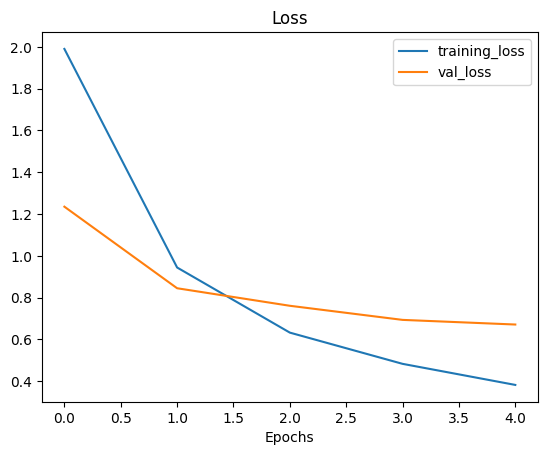

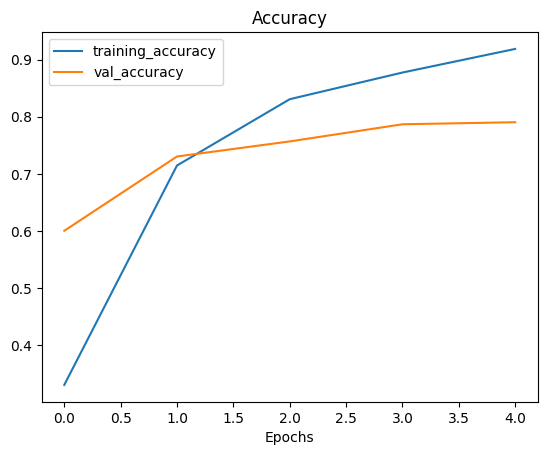

In [15]:
plot_loss_curves(resnet_history)

## Creating and testing EfficentNetB0 Tensorflow Hub Feature Extraction Model

In [16]:
# Creating EfficentNet Feature Extractor Model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile The EfficientNet Model
efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                         metrics=["accuracy"])

# Train Model with 10% of Training Data

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230924-134834
Epoch 1/5
24/24 [==============================] - 23s 535ms/step - loss: 1.8649 - accuracy: 0.4240 - val_loss: 1.3119 - val_accuracy: 0.7164
Epoch 2/5
24/24 [==============================] - 10s 435ms/step - loss: 1.0778 - accuracy: 0.7640 - val_loss: 0.8798 - val_accuracy: 0.8116
Epoch 3/5
24/24 [==============================] - 10s 420ms/step - loss: 0.7711 - accuracy: 0.8320 - val_loss: 0.7109 - val_accuracy: 0.8304
Epoch 4/5
24/24 [==============================] - 10s 426ms/step - loss: 0.6218 - accuracy: 0.8587 - val_loss: 0.6239 - val_accuracy: 0.8468
Epoch 5/5
24/24 [==============================] - 10s 418ms/step - loss: 0.5231 - accuracy: 0.8880 - val_loss: 0.5673 - val_accuracy: 0.8568


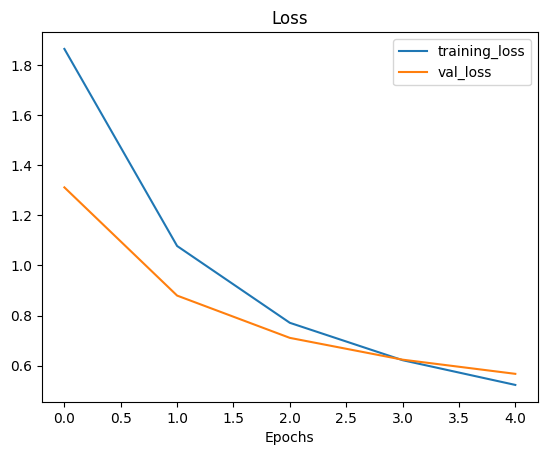

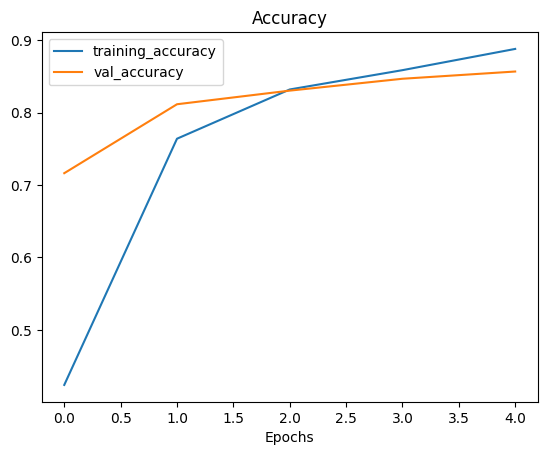

In [17]:
plot_loss_curves(efficientnet_history)

In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [19]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


## Comparing our model results using TensorBoard
  🔑 Note: When you upload things to tensorBoad.dev , your experiments are public.


In [20]:
#View your TensorBoard at https://tensorboard.dev/experiment/RKFX2V4BTV6RUYk9CEIORQ/
!tensorboard dev list

2023-09-24 13:49:41.123011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", line 46, in run_main
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308, in run
    _ru